# Heartbeat Sounds Classification using Machine Learning
DSI 13 Capstone Project: Classifying heartbeat anomalies from recorded audio

**Notebook 2: Data Preprocessing and Feature Selection**

## Importing Libraries

In [ ]:
#!pip install PyWavelets
#!pip install scaleogram

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.signal import welch

## audio
import librosa as lr
from librosa import display
import wave                    # library handles the parsing of WAV file headers
import pywt
import IPython.display as ipd  #audio playback

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import scaleogram as scg 

## others
from glob import glob
import itertools
import os
from IPython.display import Image
from skimage.transform import resize

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight

# Keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'shuffle', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Load dataset

In [3]:
df_ab = pd.read_csv('../outputs/df_ab.csv')

# 2 Pre-processing

The original recorded wav files in both set A and set B have certain level of contanmination with background noise. This is observed especially in the frequency domain spectrum in EDA. Thus, we'll need to clean the wav file to only contain as much of the wanted audio signal (i.e. the S1 & S2 heartbeat sound) before modeling.


## 2.1 Denoise audio signal

From EDA, we can hear that the recorded audio is masked with background noise. This could make it hard to detect the S1 and S2 signal.

**Denoise** by removing (high-frequency) noise using **Discrete Wavelet Transform** (DWT)

DWT is implemented as a filter-bank which can deconstruct a signal into its frequency sub-bands. It can desconstruct the noisy signal into the approximation (low pass) and detail (high pass) coefficients. 
To filter out the unwanted high frequency noise, setting the detail coefficients to zero to filter out that part of the high frequency spectrum. This can be done by using `pywt.threshold()`, which removes coefficient values higher than a given threshold. Then, reconstruct the signal again from the remaining coefficients.


source:

[Guide using wavelet transformation in machine learning](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/)

[pywavelets](https://pywavelets.readthedocs.io/en/latest/)

In [4]:
### The PyWavelets library contains 14 mother Wavelets (families of Wavelets):
### A wavelet must have 1) finite energy and 2) zero mean.
### For heartbeat sound, I will use the 'Daubechies' Wavelets to decompose as it has 
### characteristics closes to the heartbeat sound

print(pywt.families(short=False))


['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


Within each wavelet family there can be a lot of different wavelet subcategories belonging to that family. You can distinguish the different subcategories of wavelets by the number of coefficients (the number of vanishing moments) and the level of decomposition.

This is illustrated below in for **‘Daubechies’** (short-form, db), the wavelet family that I selected to decompose the heartbeat audio.

['db6', 'db7', 'db8', 'db9', 'db10']


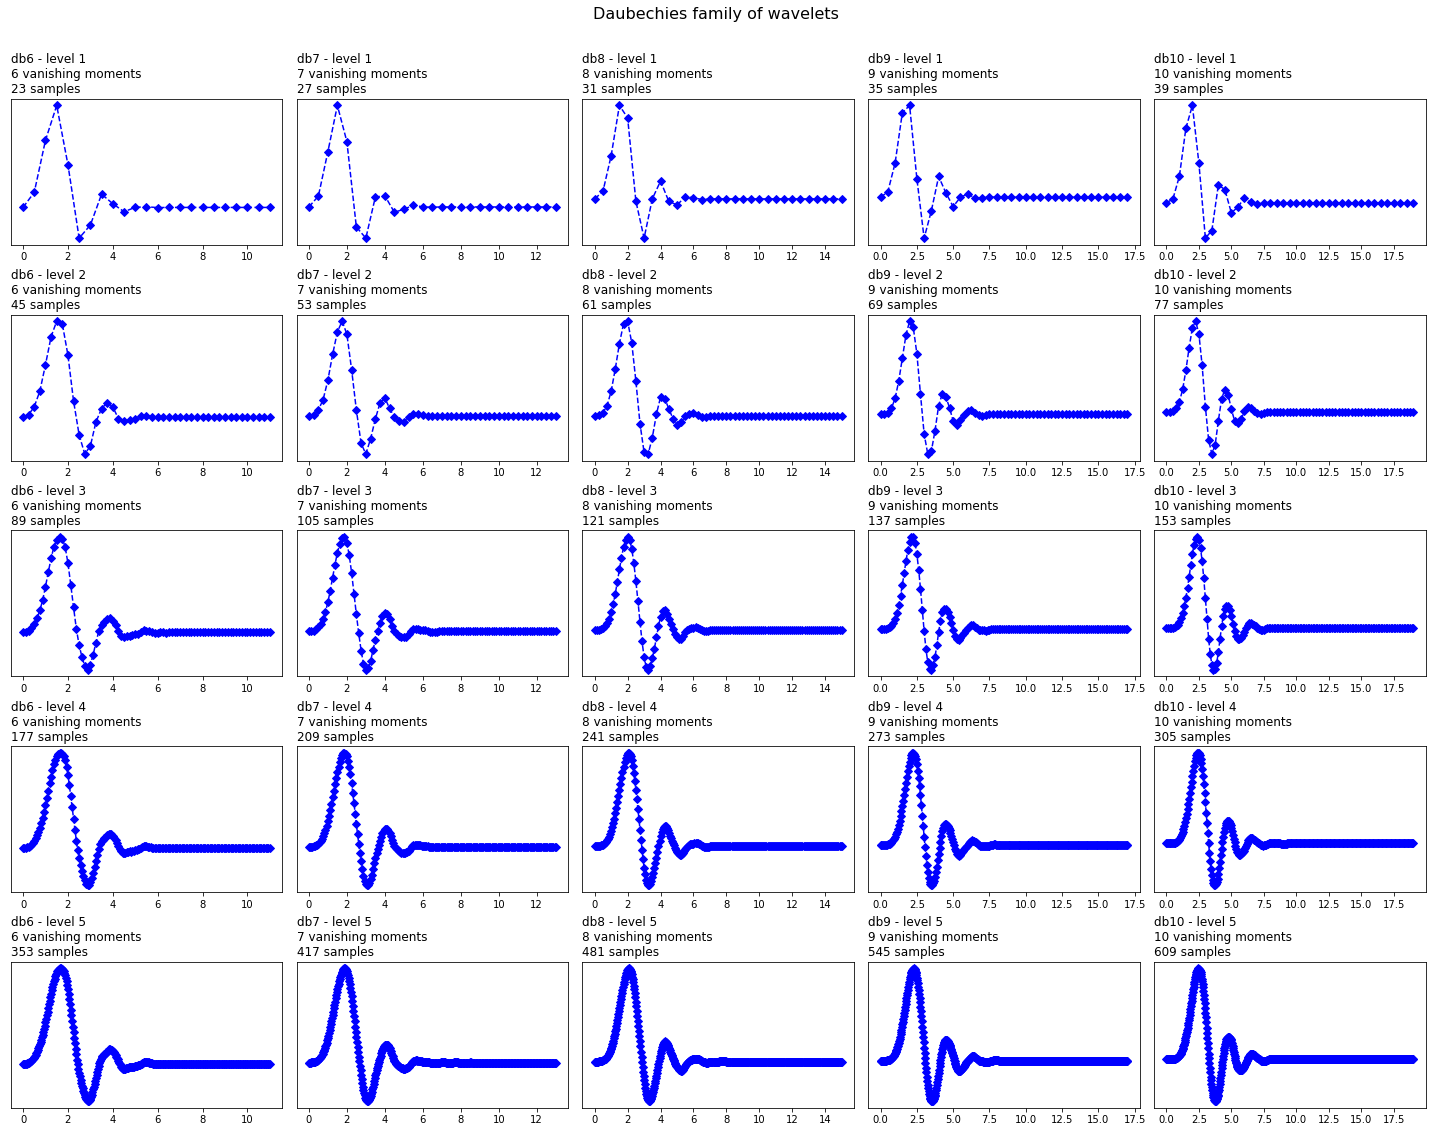

In [5]:
### plot the ‘Daubechies’ wavelet family
db_wavelets = pywt.wavelist('db')[5:10]
print(db_wavelets)

 
fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Deconstructing a signal using DWT

#### Search for wavelet subcategories and level, based on one wav file (plot shown in the subsequent cell)

- Tweak the wavelet list (from db1 and up, which increases the vanishing moment).
- Tweak the level to reduce the noise
- Tweak the threshold to include the small peak as much as possible

In [6]:
### Define function to remove the high frequency using DWT

def denoise_signal(x, wavelet='db6', level = 10):
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet=wavelet, mode="per", level= level)
     
    # Calculte the univeral threshold
    # the 0.3 value is tweak until I can reconstruct all the peak (without lefting out the small peak)
    thresh = 0.3 * np.nanmax(x)       
    coeff[1:] = ( pywt.threshold( i, value=thresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet = wavelet, mode='per' )
    

#### Select a noisy normal audio from set b to tweak the wavelet subcategories setting

In [33]:
df_ab[df_ab['label'] == 'normal_noisynormal'].head(2)

filename               label  wav_duration  \
126  134_1306428161797_D1.wav  normal_noisynormal        7.2045   
137   105_1305033453095_A.wav  normal_noisynormal       10.3900   

                                             file_path folder  
126  ../datasets/challenge2/set_b/normal_noisynorma...      b  
137  ../datasets/challenge2/set_b/normal_noisynorma...      b

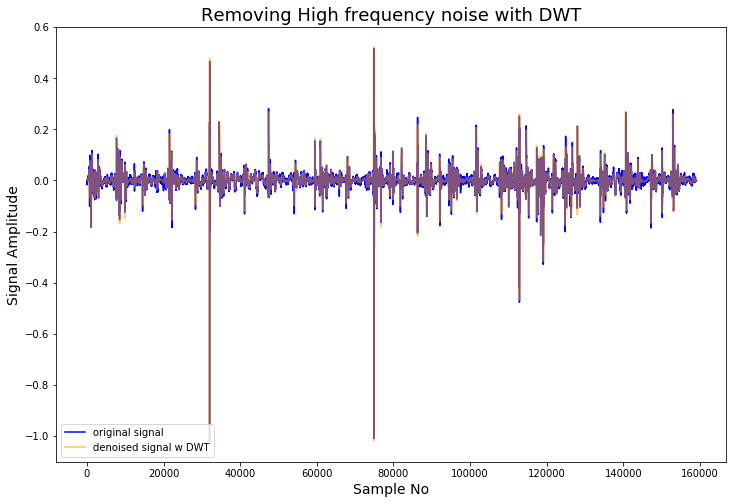

In [34]:
### denoise the signal, tweak the wavlet subcategories (this wave is use to tweak the wavelet subcategories and threshold)

### try the signal from row126 from df_ab
audio, sr = lr.load(df_ab['file_path'].loc[126], res_type='kaiser_fast')

### this is the denoised signal
rec = denoise_signal(audio)

### plot original and denoised signal in TIME DOMAIN
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(audio, color = 'b', label = 'original signal');

ax.plot(rec, 'orange', alpha = 0.5, label = 'denoised signal w DWT', linewidth =2);
ax.legend(loc = 3)

ax.set_title('Removing High frequency noise with DWT', fontsize = 18)
ax.set_ylabel('Signal Amplitude', fontsize = 14)
ax.set_xlabel('Sample No', fontsize = 14)
plt.show()


### Listen to the original and denoised signal

- It helps to filter out some high frequency noise background noise

In [35]:
### original wav
ipd.Audio(df_ab['file_path'].loc[126])

In [36]:
### denoised wav
ipd.Audio(rec, rate=sr)

### Calculate the Signal to Noise (SNR)
- Apart from visualization the waveform in time domain and listening to the audio signal, I would like to quantify the amount of noise reduction by using SNR.

In [37]:
### Define function to calculate the signal to noise ratio (SNR)
### Check how well the denoise

def snr(audio, thresh):
    thresh = thresh * np.nanmax(audio)
    
    ### extract the signal exceed the threshold
    signal_sq = [i**2 for i in audio if i >= thresh]
    signal_rms =  np.sqrt(sum(signal_sq) / len(signal_sq))
    
    ### calculate the noise (i.e. data not included in signal above)
    noise_sq = [i**2 for i in audio if i < thresh]
    noise_rms = np.sqrt(sum(noise_sq) / len(noise_sq))
    #noise_rms = signal.std(axis =0, ddof =0)
    
    return 20*np.log10(signal_rms/noise_rms)


#### Calculate SNR on the noisy normal heartbeat sound from set b

- The above audio sound is selected to find the suitable subcategories of Daubechiese (short-form, 'db) wavelet to decompose and denoise the heartbreat audio, as it has high unwanted background noise.
- From the time domain plot, it suppresses some of the noises, however, the calculated SNR only improves by around 0.5dB. Thus, there are still substantial amount of background noise did not suppress.
- Proceed to check the denoise performance on other recorded heartbeat audio (10 each from set a and set b)

In [38]:
### SNR
print(f'original SNR: {round(snr(audio, 0.5),2)}')
print(f'Denoised SNR: {round(snr(rec, 0.5),2)}')

original SNR: 20.55
Denoised SNR: 21.2


In [39]:
### Define plot function to plot the frequency spectrum of the de-noised signal

def simfft_plot(signal, sfreq, label):
    n = len(signal)
    
    #check if the len of audio data is odd number
    if n%2 !=0:
        n = n+1   # if size of audio data is in odd number, add one to it before proceed
    
    t = 1/sfreq
    yf = scipy.fft(signal)
    xf = np.linspace(0.0, 1.0/(2.0*t), n//2)
    plt.plot(xf, 2.0/n * np.abs(yf[:n//2]), label = label)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  # This is added back by InteractiveShellApp.init_path()


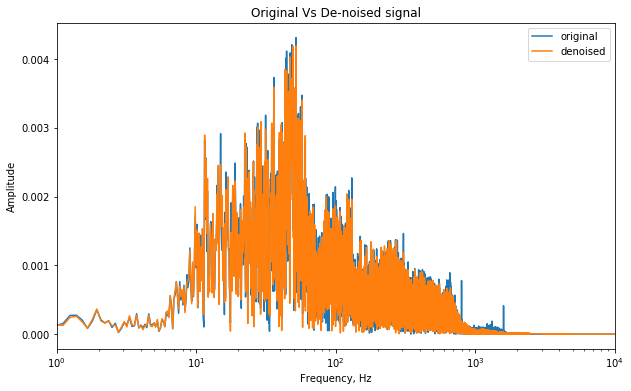

In [40]:
### plot the de-noised signal in FREQUENCY DOMAIN
### Denoise remove the high frequency signal only

plt.subplots(figsize=(10,6))
simfft_plot(audio, sr, 'original');
simfft_plot(rec, sr, 'denoised');
plt.xscale('log')
plt.xlim(1, 10000)
plt.legend(loc = 1);
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude')
plt.title('Original Vs De-noised signal');


### Denoised 10 audio signal from each folder and plot the signal in time domain

- the selected wavelet and threshold setting is able to denoise those noisy audio with high frequency content. 
- as expected, it cannot remove the background noise with lower frequency.
- SNR is calculated, and it removes the noise from 0dB up to around 5dB, depending the type of noise exist in the audio signal.

**To use 'db6' and level 10 to perform DWT to remove the high frequency noise of the heartbeat audio**

In [41]:
### load first 10 audio wav in set_a into array using librosa, and store in y_a
y_a = []

for i in range(10):
    y, sr = lr.load(df_ab['file_path'][i], 
                    res_type = 'kaiser_fast')   # use kaiser_fast technique for faster extraction
    y_a.append(y)
    
len(y_a)

10

In [42]:
### load first 10 audio wav in set_b into array using librosa, and store in y_b
y_b = []

for i in range(10):
    y, sr = lr.load(df_ab['file_path'][i+124],   #wav file from set_b start from row 124
                    res_type = 'kaiser_fast') 
    y_b.append(y)
    
len(y_b)

10

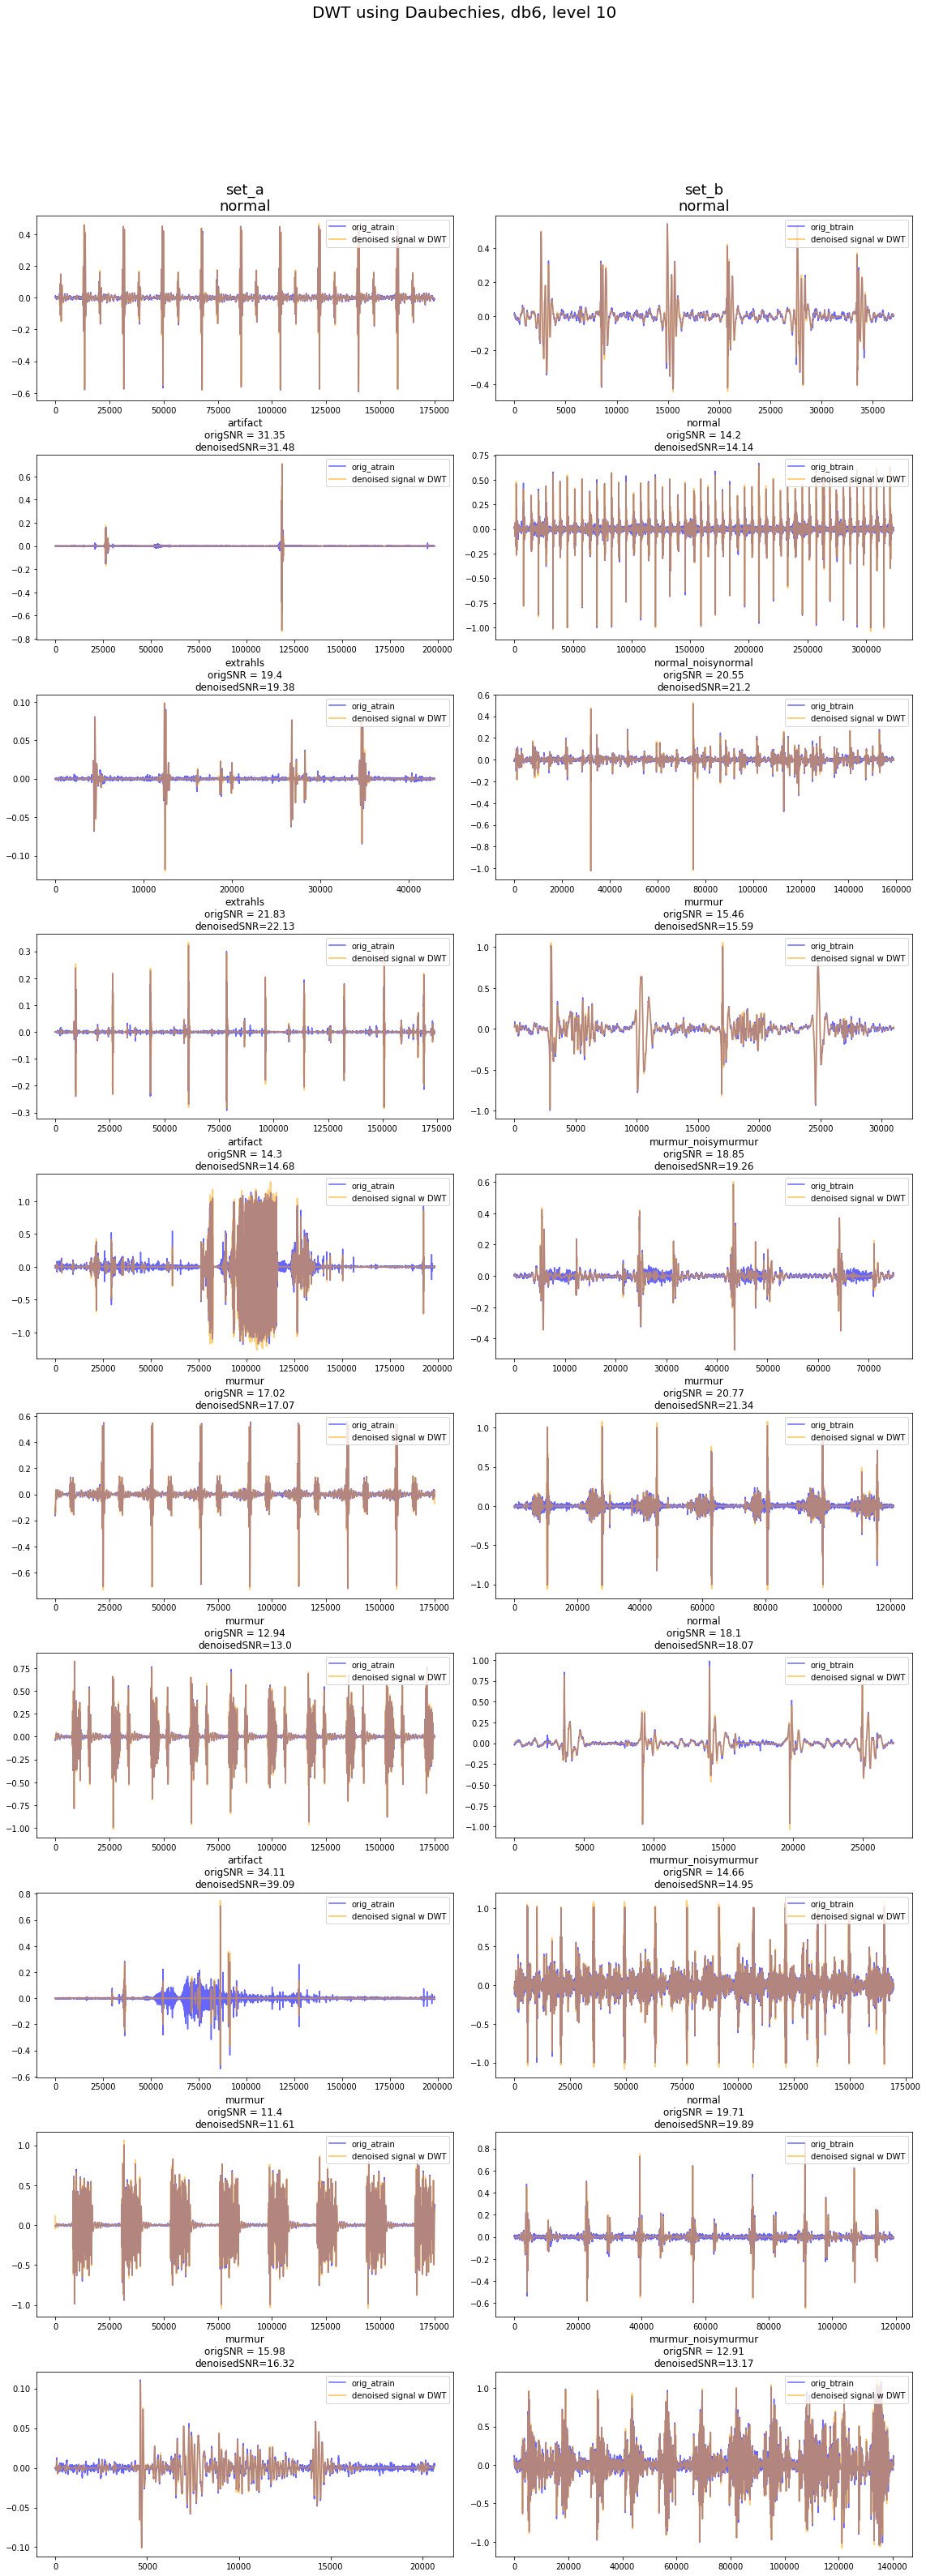

In [43]:
### Plot the denoised audio wav 
fig, ax = plt.subplots (ncols = 2, nrows = 10, figsize = (16, 45))
fig.suptitle('DWT using Daubechies, db6, level 10', fontsize = 20)
snr_orig, snr_denoise = [], []
denoise_a, denoise_b = [], []

for i in range(10):
    signala = y_a[i]    
    signalb = y_b[i]
    
    ### this is the denoised signal
    rec_a = denoise_signal(signala)
    rec_b = denoise_signal(signalb)
    
    # store the denoised signal
    denoise_a.append(rec_a)
    denoise_b.append(rec_b)
    
    ### calculate SNR
    snr_a = snr(signala, 0.5)
    snr_b = snr(signalb, 0.5)
    snr_rec_a = snr(rec_a, 0.5)
    snr_rec_b = snr(rec_b, 0.5)
    
    # store the calculated SNR
    snr_orig.extend([snr_a,snr_b ])
    snr_denoise.extend([snr_rec_a,snr_rec_b ])
 
    
    ### plot original and denoised signal in TIME DOMAIN
    ax[i,0].plot(signala, color = 'b', alpha = 0.6, label = 'orig_atrain');
    ax[i,0].plot(rec_a, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,0].set_title(f"{df_ab['label'][i]}\norigSNR = {round(snr_a,2)}\ndenoisedSNR={round(snr_rec_a,2)}")
    ax[i,0].legend(loc =1)
    
    ax[i,1].plot(signalb, color = 'b', alpha = 0.6, label = 'orig_btrain');
    ax[i,1].plot(rec_b, 'orange', alpha=0.5, label='denoised signal w DWT', linewidth = 2);
    ax[i,1].set_title(f"{df_ab['label'][i+124]}\norigSNR = {round(snr_b,2)}\ndenoisedSNR={round(snr_rec_b,2)}")
    ax[i,1].legend(loc =1)
    

ax[0,0].set_title(f"set_a\n{df_ab['label'][0]}", fontsize=18);
ax[0,1].set_title(f"set_b\n{df_ab['label'][124]}", fontsize=18);
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [44]:
### SNR of original Vs denoised audio wav (10 each from set a and set b)
snr = pd.DataFrame(list(zip(snr_orig, snr_denoise)), columns = ['Original SNR', 'Denoised SNR'])
snr['SNR delta'] = snr['Denoised SNR'] - snr['Original SNR']
snr

Original SNR  Denoised SNR  SNR delta
0      15.999260     16.069137   0.069877
1      14.576495     14.678683   0.102188
2      31.353450     31.476168   0.122718
3      14.200094     14.141590  -0.058504
4      19.398586     19.383125  -0.015461
5      20.551966     21.201159   0.649193
6      21.827334     22.125163   0.297829
7      15.456556     15.589606   0.133051
8      14.304618     14.679441   0.374823
9      18.849073     19.258128   0.409055
10     17.024615     17.072139   0.047524
11     20.772725     21.337783   0.565059
12     12.943065     13.003634   0.060569
13     18.096290     18.074842  -0.021448
14     34.112788     39.092442   4.979654
15     14.657633     14.952561   0.294928
16     11.397117     11.606561   0.209444
17     19.712983     19.887031   0.174048
18     15.980306     16.316817   0.336511
19     12.907458     13.172278   0.264819

# 3 Feature Selection

Audio data can be represented in time domain and frequency domain. 

![audio](../image/time_freq_domain.jpeg)

To classify the un-structure audio data, we first need to identify which feature to extact for machine learning. The selected feature needs to be able to describe the characteristics of heart sounds well. 

There are several audio features can be extracted from the audio data. The goal is to extract the identifiable components of the heartbeat signals, which can be used to train the machine learning mordel to classify them according to the label (normal, murmur, extrahls, & etc).

Features considered in this project are:
1. Spectrogram
2. Mel Frequency Cepstral Coefficents (MFCCs)
3. Continous Wavelet Transform (CWT)

## 3.1 Spectrogram

So far, we only view the signal in either time domain or frequency domain (as illustrated in above picture), which, if in time domain, there is no information about how the signal change in time, and vice versa. 

A spectrogram is a visual representation of the spectrum of frequencies of signal as it vary with time. It’s a representation of frequencies changing with respect to time for signal.

Below cells plot the spectrogram of the first 6 audio wav from each folder (set a & set b). Different audio wav have different patterns in the spectrogram, which we could train our model to classify the pattern.


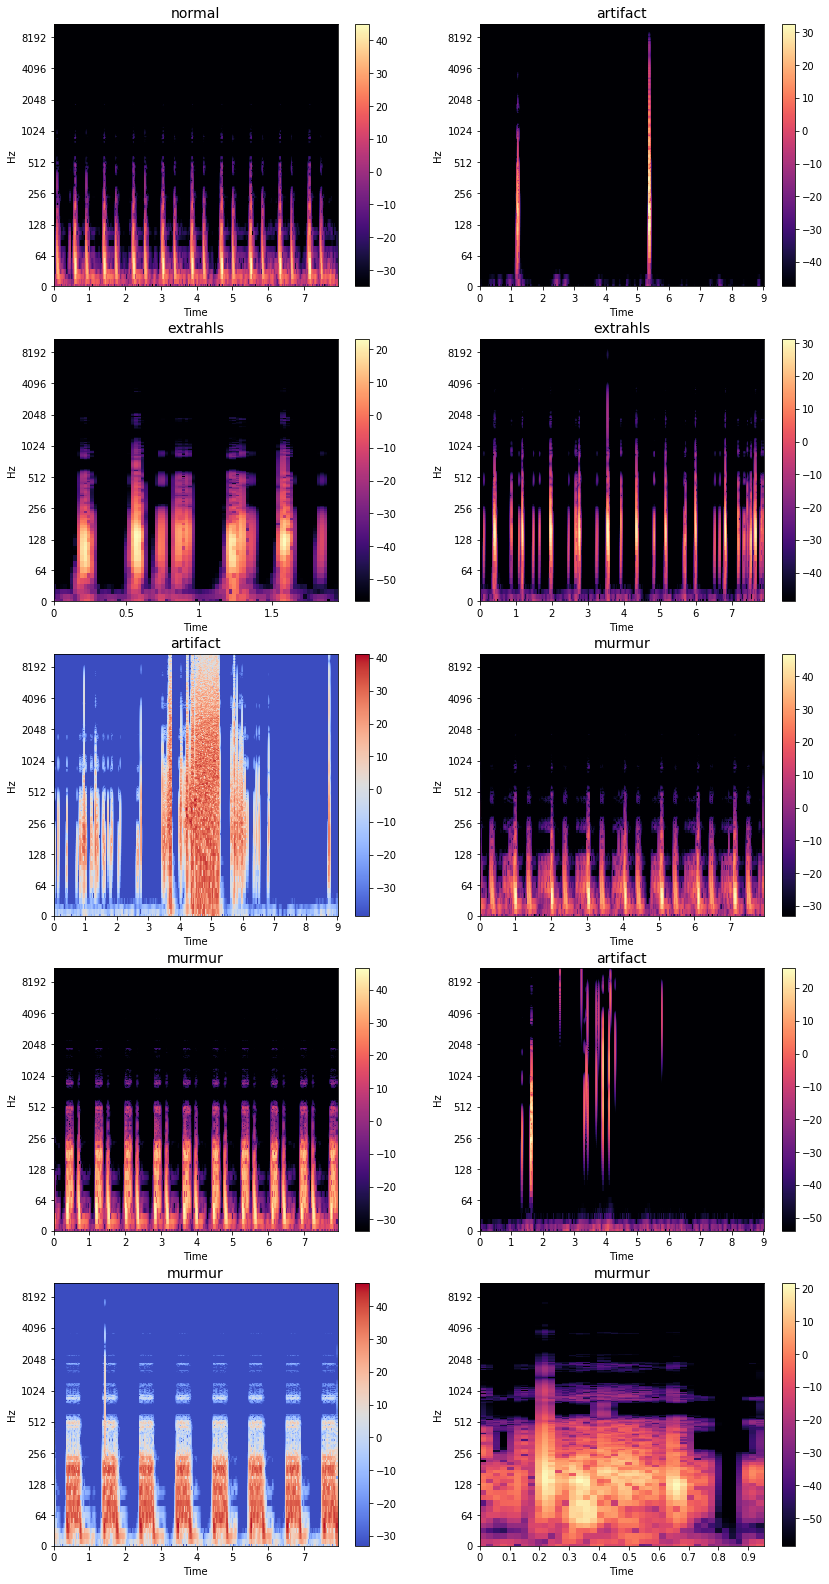

In [45]:
# Spectrogram from set_a folder:

plt.figure(figsize = (14,28))
for i in range(10):
    rec_a = denoise_a[i]    
    
    ### calculate the short-time fourier transform
    X_a = lr.stft(rec_a)
    
    ### convert the signal to log-scale
    Xa_db = lr.amplitude_to_db(abs(X_a))

    ### plot spectrogram
    
    subplot(5,2,i+1)
    lr.display.specshow(Xa_db, sr = 22050, x_axis = 'time', y_axis = 'log')
    plt.title(df_ab['label'][i], fontsize=14)
    plt.colorbar();

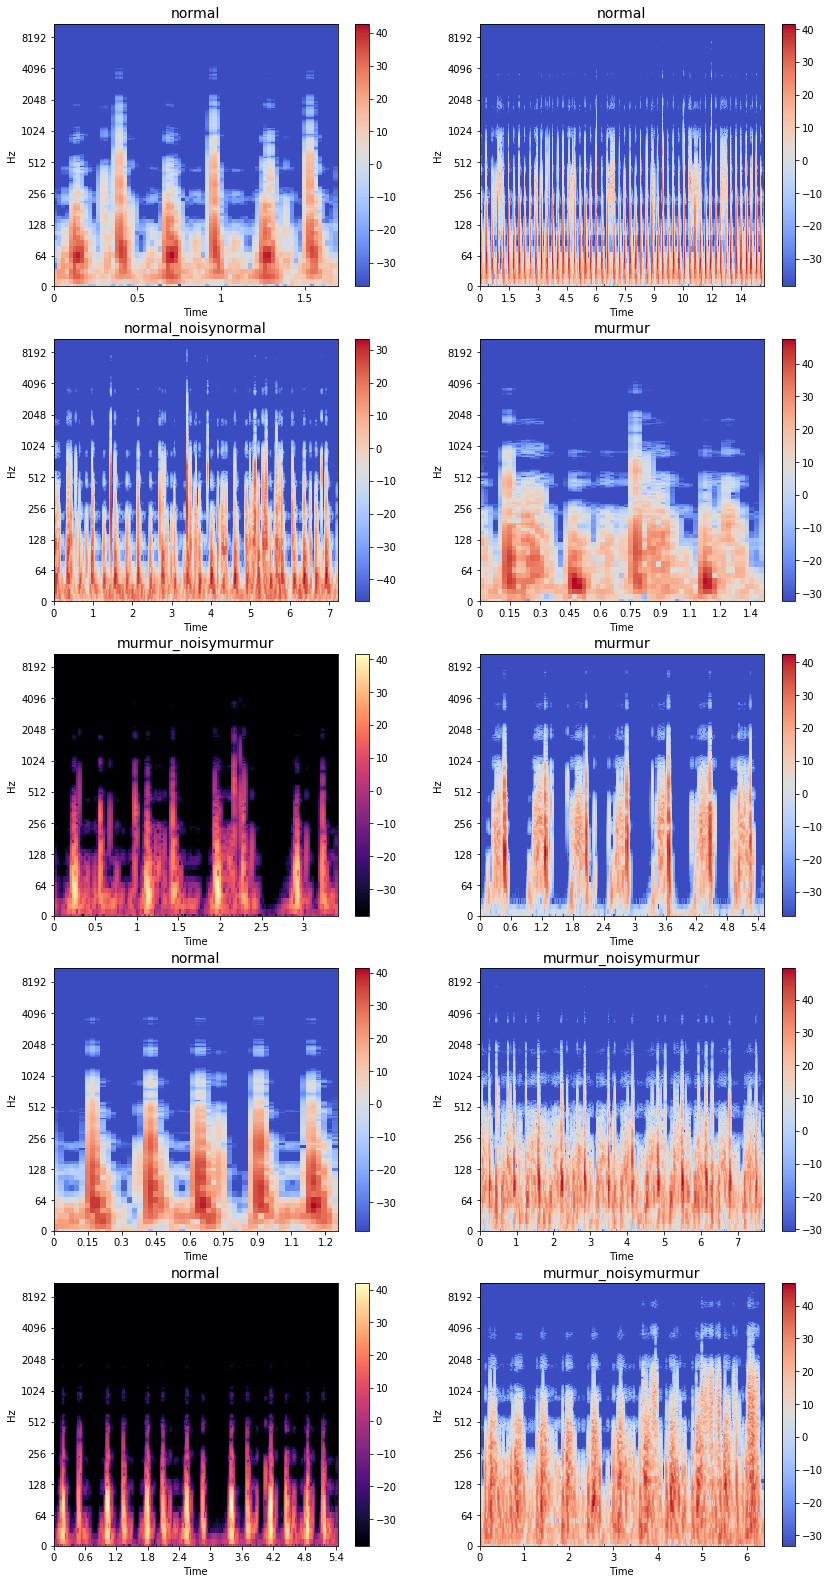

In [46]:
# Spectrogram from set_b folder:

plt.figure(figsize = (14,28))
for i in range(10):
    rec_b = denoise_b[i]    
    
    ### calculate the short-time fourier transform
    X_b = lr.stft(rec_b)
    
    ### convert the signal to log-scale
    Xb_db = lr.amplitude_to_db(abs(X_b))

    ### plot spectrogram
    
    subplot(5,2,i+1)
    lr.display.specshow(Xb_db, sr = 22050, x_axis = 'time', y_axis = 'log')
    plt.title(df_ab['label'][i+124], fontsize=14)
    plt.colorbar();


## 3.2 MFCC

Apart from the spectrogram, a more popular techniques to extract features from audio signals is computing the MFCC (**Mel Frequency Cepstral Coefficients**) from the raw audio signal.

MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. 

Process of extracting MFCC is shown in below block diagram:
![mfcc](../image/MFCC.png)


**Generating MFCC using Librosa**
The library librosa has a function to calculate MFCC. Cell below shows the step to compute the MFCC from librosa.

references: 
[librosa.feature.mfcc](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)
[mfcc](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)
[mfcc tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)


In [47]:
### Librosa's mfcc() function is able to generates an MFCC from time series audio data.
### Code below is an example of extracting an audio (murmur heartbeat from set_a ~ 1sec long)
### It returns 20 MFCCs over 41 frames. Longer audio will have longer frames

mfcc = lr.feature.mfcc(y = rec_a, sr = 22050, n_mfcc = 20)
mfcc.shape

(20, 41)

### Define function to normalize the MFCC

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in `[0, 1]`.

In [48]:
def feature_normalize(data):               # data is in numpy array (40,x)
    data_normalize = []
    data_max = np.max(data, axis =0)       # max value per row, 
    data_min = np.min(data, axis =0)       # min value per row
    for i in range(len(data)):
        data_nor = [(x - data_min[i])/(data_max[i] - data_min[i]) for x in data[i]] #normalize each value in 'x'
        data_normalize.append(data_nor)
    return np.asarray(data_normalize)      #convert back to numpy array

#### Visualize MFCC feature

The following cell will plot the MFCC feature of the first 6 audio wav from set_a and set_b folder respectively.

The X-axis is the time (s), and the y-axis is the 20 bands (or 20 mels).
Similarly, there are patterns on each audio wav, which, we can train our model to classify the heartbeat audio based on the patterns.


Mel-Frequency Cepstral Coefficients (MFCCs) from set_a


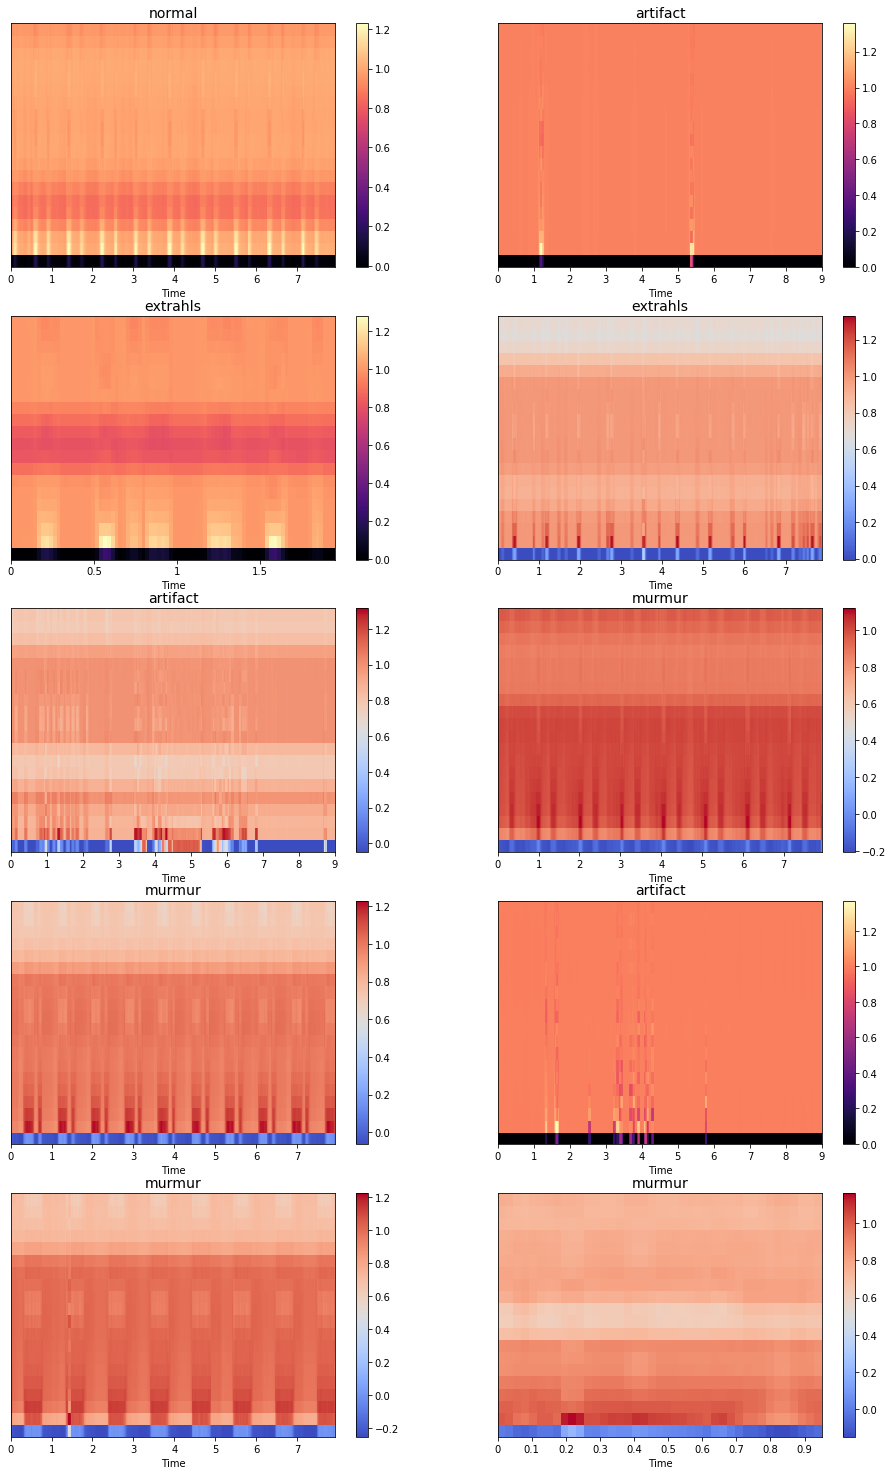

In [51]:
# Visualize MFCC feature of audio signal from set_a folder: 

print("Mel-Frequency Cepstral Coefficients (MFCCs) from set_a")

plt.figure(figsize = (16,26))
for i in range(10):
   
    # get the mfcc feature
    mfccs = lr.feature.mfcc(y = denoise_a[i], sr = 22050, n_mfcc = 20)
    # Normalize mfccs to be within [0,1]
    mfccs_sc = feature_normalize(mfccs)
    
    ### plot mfcc
    subplot(5,2,i+1)
    lr.display.specshow(mfccs_sc, x_axis = 'time')
    plt.title(df_ab['label'][i], fontsize=14)
    plt.colorbar();

Mel-Frequency Cepstral Coefficients (MFCCs) from set_b


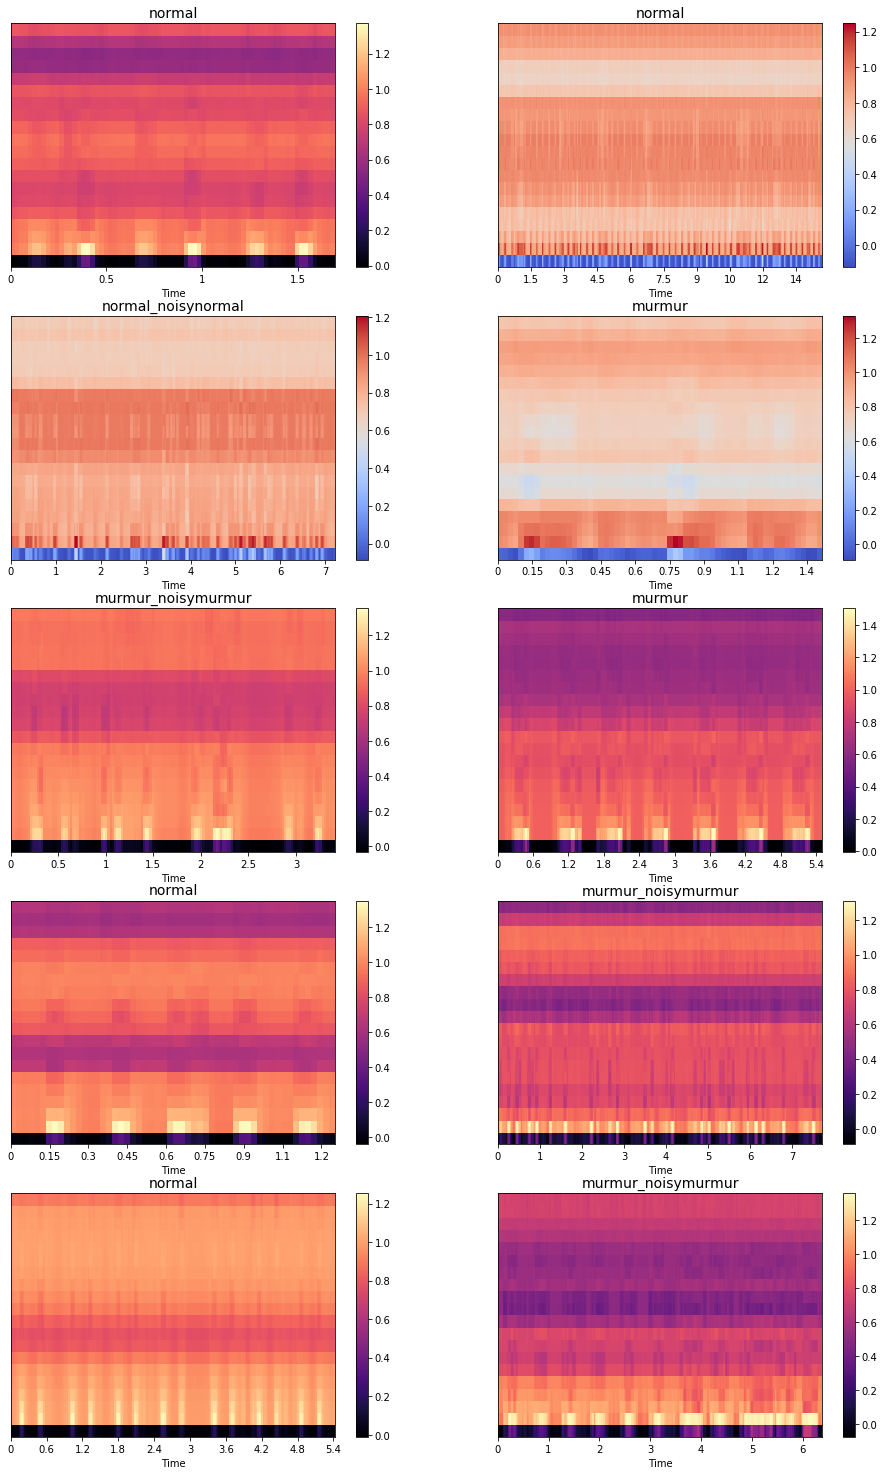

In [52]:
# Visualize MFCC feature of audio signal from set_b folder:

print("Mel-Frequency Cepstral Coefficients (MFCCs) from set_b")

plt.figure(figsize = (16,26))
for i in range(10):
   
    # get the mfcc feature
    mfccs = lr.feature.mfcc(y = denoise_b[i], sr = 22050, n_mfcc = 20)
    # Normalize mfccs to be within [0,1]
    mfccs_sc = feature_normalize(mfccs)
    
    ### plot mfcc
    subplot(5,2,i+1)
    lr.display.specshow(mfccs_sc, x_axis = 'time')
    plt.title(df_ab['label'][i+124], fontsize=14)
    plt.colorbar();

## 3.3 Continuous Wavelet Transform (CWT)

Wavelet transform an 1-dimensional signal to two dimensions. This 2-dimensional output of the Wavelet transform is the time-scale representation of the signal in the form of a **scaleogram**.

In the context of this project, the output of a wavelet transform on a 1D signal (i.e. heartbeat audio, load from Librosa lib as 1D numpy array) is a 2D  **time-pitch-power** scaleograms. It gives a representation of the sound with time in horizontal axis, pitch (frequency) in vertical axis and power in the darkness of a pixel.


References:

[Continuous Wavelet Transform (CWT)](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html)

[A gentle introduction to wavelet for data analysis](https://www.kaggle.com/asauve/a-gentle-introduction-to-wavelet-for-data-analysis)

[For basic conversion between scales and time/frequency domain values by A. Sauve](https://github.com/alsauve/scaleogram/blob/master/doc/scale-to-frequency.ipynb)

### Wavelet Families

Different families have different shapes, which enable us to choose the one that fits best with the features that we are looking for in our signal. Most common wavelets for CWT are the “Mexican, Morlet and Gaussian” wavelet. They are called 'Mother Wavelets'. For this project, I choose Shannon wavelets, which is better fit to the heartbeat audio. 

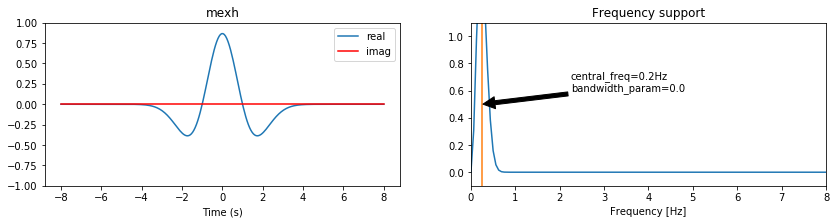

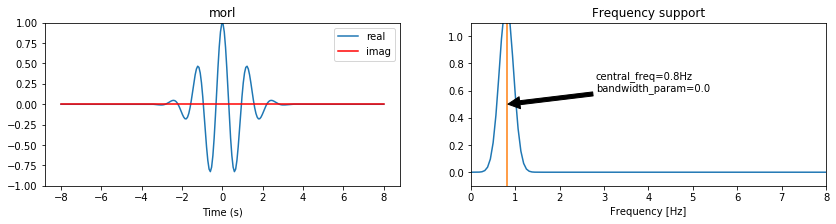

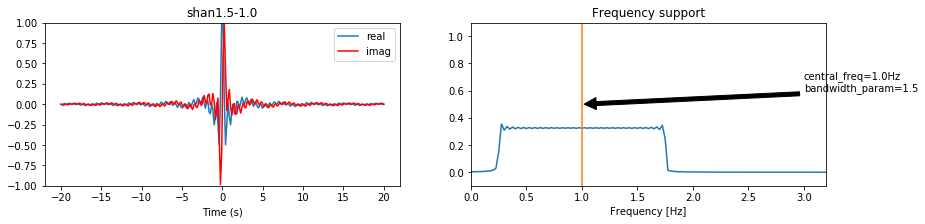

In [53]:
axes = scg.plot_wav('mexh', figsize=(14,3))  #Mexican hat wavelet
axes = scg.plot_wav('morl', figsize=(14,3))  # Morlet wavelet
axes = scg.plot_wav('shan1.5-1.0', figsize=(14,3))   # Shannon wavelet

### Visualize scaleogram for 1 randomly selected normal heartbeat audio

- sampling frequency, sfr = 2kHz
- wav length = sfr *x* 3 (3 sec)

Wavelet function used to compute the transform: shan1.5-1.0 ( Shannon wavelets )


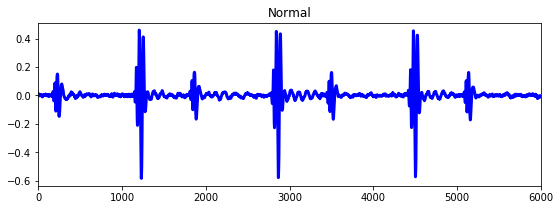

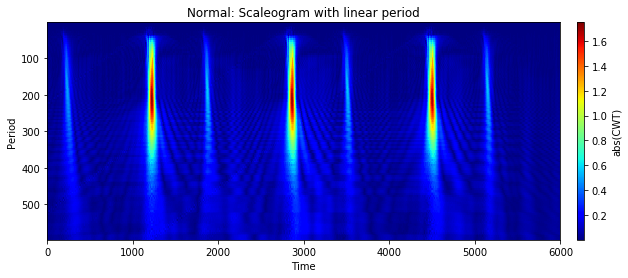

In [54]:
### Visualize the normal heartbeat in time domain Vs Scaleogram
# choose default wavelet function
scg.set_default_wavelet('shan1.5-1.0')

sfr = 2000
period_length = 600 #up to 600Hz
signal_length = 3*sfr
# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   # give len of 120


# load normal heartbeat from audio
y_normal, sfr = lr.load(df_ab['file_path'][0], sr = sfr)

# plot heartbeat in time domain
fig1, ax1 = plt.subplots(1,1, figsize = (9, 3));
ax1.plot(y_normal[:signal_length], linewidth = 3, color = 'blue')
ax1.set_xlim(0, signal_length)
ax1.set_title('Normal')

# plot scaleogram
scg.cws(y_normal[:signal_length], scales=scales, figsize = (10, 4), coi = False, ylabel = 'Period',
        xlabel = 'Time', title = 'Normal: Scaleogram with linear period');
print("Wavelet function used to compute the transform:", scg.get_default_wavelet(), 
      "(", pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

### Visualize Scaleogram for all 5 categories of heartbeat audio

In [55]:
%%time

### Compile the audio signal and perform CWT
select_list = [0, 126, 5, 131, 3, 135, 4, 137]
waveletname = 'shan1.5-1.0'

y_dsample, coeffs = [], []  # list to store the down-sample audio signal and the coefficients after CWT transform

# load audio signal from its wav file
for i in select_list:
    y, sfr = lr.load(df_ab['file_path'][i], sr = sfr)
    y_dsample.append(y)

# CWT transform
for j in range(len(y_dsample)):
    coef, freq = pywt.cwt(y_dsample[j][:signal_length], scales, waveletname, 1)
    coeffs.append(coef)  

CPU times: user 9.12 s, sys: 66.4 ms, total: 9.18 s
Wall time: 9.38 s


Heartbeat Audio in Time Domain and its' Scaleogram


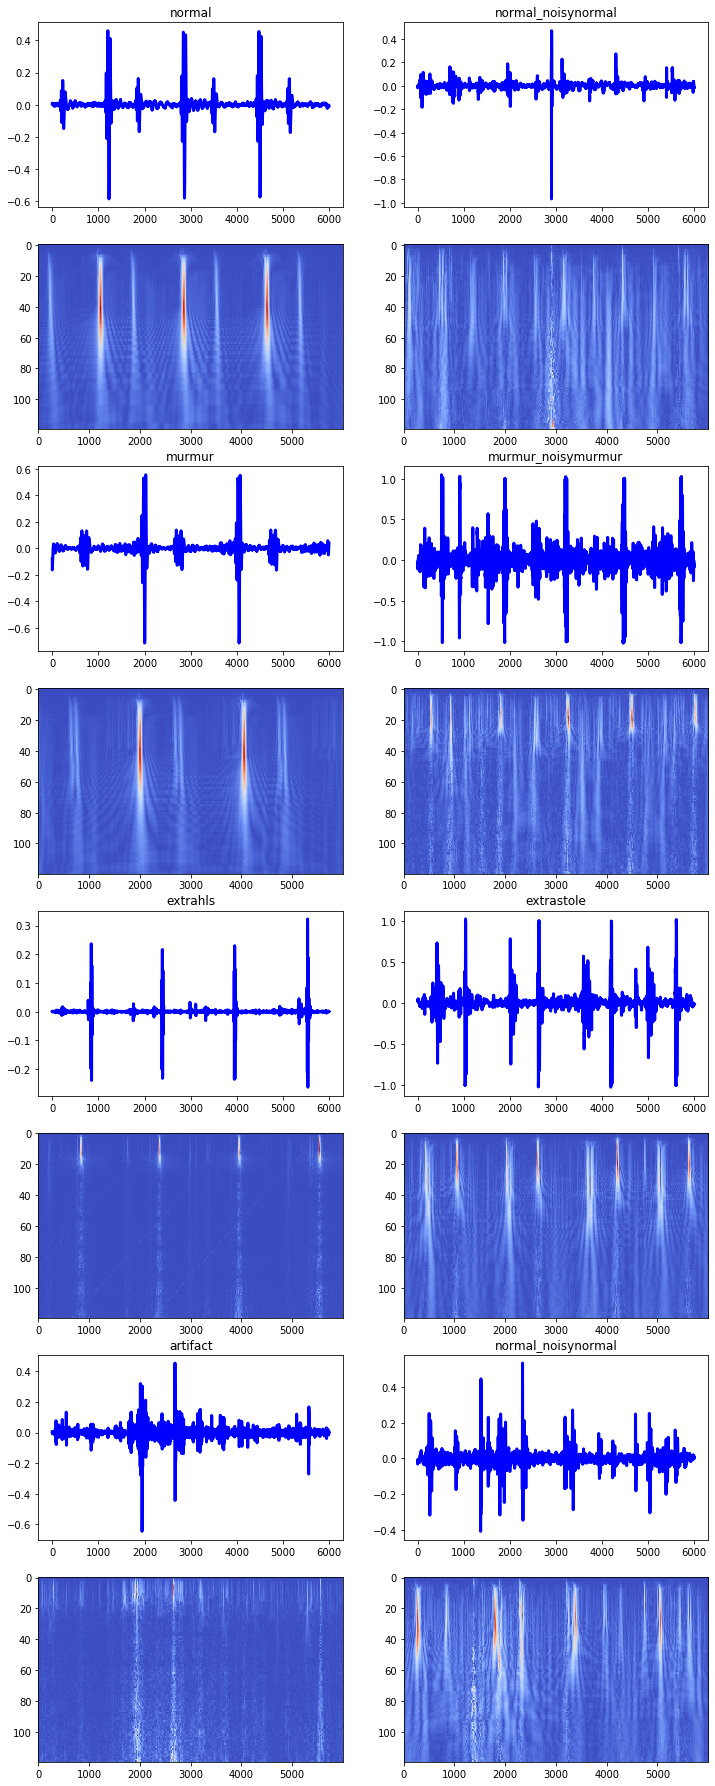

In [56]:
### Plot heartbeat audio in Time Domain and Scaleogram
print("Heartbeat Audio in Time Domain and its' Scaleogram")

fig, axs = plt.subplots(nrows = 8, ncols = 2, figsize = (12, 32));
# plot audio in time domain
for row in [0,2,4,6]:
    axs[row,0].plot(y_dsample[row][:signal_length], linewidth = 3, color = 'blue')
    axs[row,0].set_title(df_ab['label'][select_list[row]])
    axs[row,1].plot(y_dsample[row+1][:signal_length], linewidth = 3, color = 'blue')
    axs[row,1].set_title(df_ab['label'][select_list[row+1]])

# plot scaleogram
for row in [1,3,5,7]:
    axs[row,0].imshow(abs(coeffs[row-1]), cmap = 'coolwarm', aspect = 'auto')
    axs[row,1].imshow(abs(coeffs[row]), cmap = 'coolwarm', aspect = 'auto')

### Resize the coefficient matrices
- The original coefficient matrices after CWT transform is (150x6000), where 6000 is the sample extracted (i.e. 3 sec audio duration from sampling rate of 2kHz).
- To downsize the coefficient matrices to several sizes: (150 x1000), (150x600), (150x300),(150x150), and (120x120) to saves many parameters and computation resources and at the same time. Finally, selected the resize of **(120x120)** as it reduce the compulational time in modeling tremendously and with **MY ASSUMPTION of it does not loose too many details of the images**.
- Cell below perform the resize (120x120) and subsequent cell plot the resize image versus the original image

In [57]:
from skimage.transform import resize

rescale_coeffs = []

for i in range(len(coeffs)):
    rescale = resize(abs(coeffs[i]), (len(coeffs[i]), 120), mode = 'constant')
    rescale_coeffs.append(rescale)

Scaleogram Original size 120x6000 versus resize 120x120


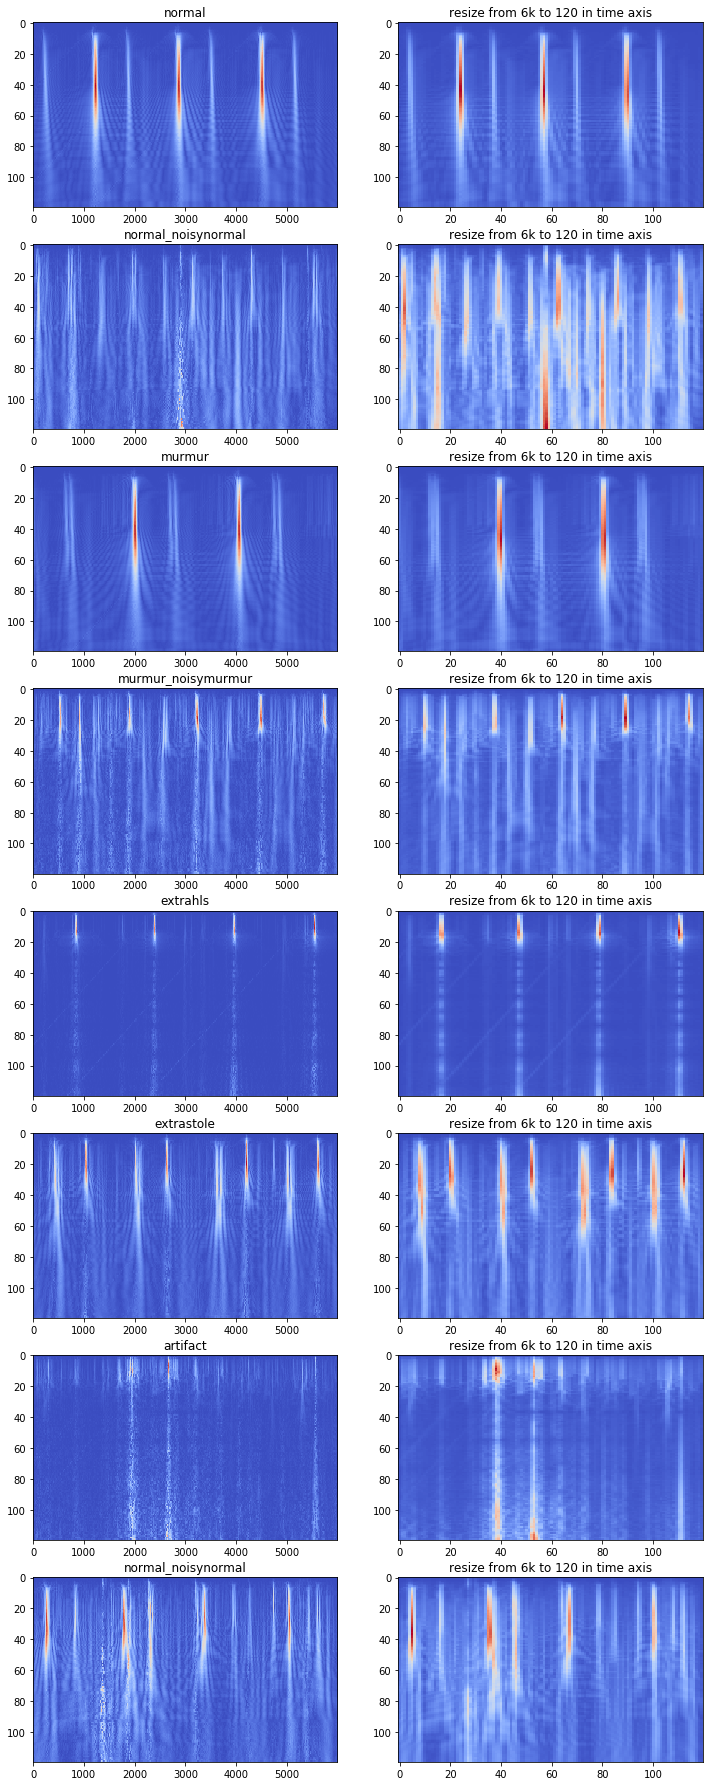

In [58]:
### Plot heartbeat audio Scaleogram
print("Scaleogram Original size 120x6000 versus resize 120x120");

fig, axs = plt.subplots(nrows = 8, ncols = 2, figsize = (12, 32));

for row in range(8):
    axs[row,0].imshow(abs(coeffs[row]), cmap = 'coolwarm', aspect = 'auto')
    axs[row,0].set_title(df_ab['label'][select_list[row]])
    axs[row,1].imshow(rescale_coeffs[row], cmap = 'coolwarm', aspect = 'auto')
    axs[row,1].set_title("resize from 6k to 120 in time axis")

# 4 Feature Extraction and Preparing X matrix and y label

## 4.1 Combine dataset from folder set_a and set_b

- For label's heartbeat audio, the audio duration varies from as short as 0.8 sec up to 27.9 sec, with mean at 6.8sec. Label's heartbeat audio will be used for traning the model.
- For unlabel's heartbeat audio, the shortest duration is >1s.
- Thus, will drop the short audio wav for labeled audio (i.e. <1sec) and standardize the wav duration to 3 sec long. Zero padding on the audio ranges between 1sec to 3 sec. Note, the heart rate may vary from **40 to 140 beats per minute**. This means, it has at least 2.3 beats ('lub dub' as 1 beat) per second.

In [59]:
df_ab.groupby('label').describe()

wav_duration                                          \
                          count      mean       std       min       25%   
label                                                                     
artifact                   40.0  9.000000  0.000000  9.000000  9.000000   
extrahls                   19.0  6.872237  2.806419  0.936372  6.061406   
extrastole                 46.0  5.858043  3.126281  1.874500  3.604875   
murmur                    100.0  7.668351  4.181701  0.856750  4.571000   
murmur_noisymurmur         29.0  8.138500  3.788688  1.340500  5.142750   
normal                    231.0  4.811620  3.040182  0.763250  2.353000   
normal_noisynormal        120.0  9.218317  4.985372  1.633500  5.040062   

                                                   
                         50%        75%       max  
label                                              
artifact            9.000000   9.000000   9.00000  
extrahls            8.013923   9.000000   9.00000  
extrastole          5.153750   7.717125  13.38075  
murmur              7.935556   8.884059  24.16000  
murmur_noisymurmur  8.505500  11.292750  16.92675  
normal              3.763250   7.449548  14.68000  
normal_noisynormal  9.122375  12.243750  27.86700

Text(0, 0.5, 'Duration, sec')

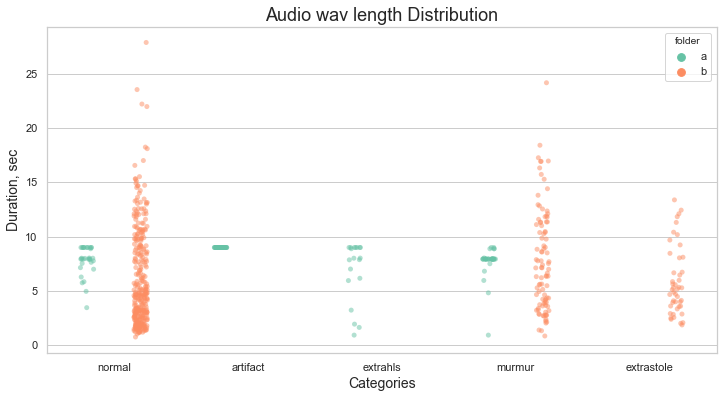

In [300]:
### Plot of audio length distribution
#sns.set(style = "whitegrid")
plt.figure(figsize = (12,6));
ax = sns.stripplot(y='wav_duration', x='label', 
                   data=df_ab, 
                   jitter=True,
                   dodge=True,
                   marker='o', 
                   alpha=0.5,
                   hue='folder',
                   palette="Set2");
ax.set_title('Audio wav length Distribution', fontsize=18)
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Duration, sec', fontsize =14)

In [60]:
### unlabel wav in set a duration distribution. The shortest audio wav is 1.75sec.
df_aunlabel_sorted = pd.read_csv('../outputs/df_aunlabel_sorted.csv')
df_aunlabel_sorted.describe()

wav_duration
count     52.000000
mean       8.129329
std        1.350243
min        1.754875
25%        7.935556
50%        8.590533
75%        9.000000
max        9.000000

In [61]:
### unlabel wav in set b duration distribution. The shortest audio wav is 1.03sec.
df_bunlabel_sorted = pd.read_csv('../outputs/df_bunlabel_sorted.csv')
df_bunlabel_sorted.describe()

wav_duration
count    195.000000
mean       6.717382
std        5.031304
min        1.027500
25%        2.920500
50%        4.764750
75%        9.694625
max       24.448750

In [62]:
### group of audio wav < 1sec (for labeled dataset). There are only 4 audio wav with duration Z< 1sec.
print(f"shape combined datasets: {df_ab.shape}")
print(f"shape wav dur < 1sec: {df_ab[df_ab['wav_duration']<1].shape}")
      
df_ab[df_ab['wav_duration']<1].groupby('label').count()

shape combined datasets: (585, 5)
shape wav dur < 1sec: (4, 5)


filename  wav_duration  file_path  folder
label                                              
extrahls         1             1          1       1
murmur           2             2          2       2
normal           1             1          1       1

In [63]:
### drop audio wav with duration < 1sec
df_ab = df_ab[df_ab['wav_duration']>1]

### merge noisy murmur too murmur, and merge noisy normal to normalb
df_ab['label'].replace({'murmur_noisymurmur':'murmur', 'normal_noisynormal':'normal'}, inplace = True)

In [64]:
### Percentage of audio wav per group (combined dataset_ab, and after droping short audio, dur <1sec)
round(df_ab.groupby('label')['filename'].count()/df_ab.shape[0]*100, 2)

label
artifact       6.88
extrahls       3.10
extrastole     7.92
murmur        21.86
normal        60.24
Name: filename, dtype: float64

#### The dataset is imbalanced multiclass
**Normal** is majority class at ~ **60%**

Distribution of each categories shown below

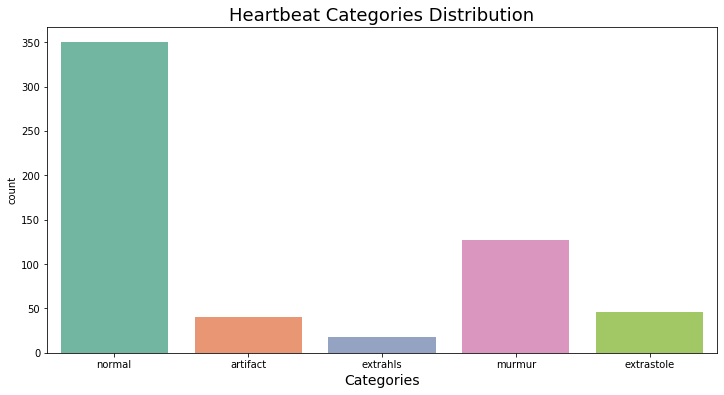

In [65]:
### Plot of categories distribution
#sns.set(style="darkgrid");
plt.figure(figsize = (12,6));
ax = sns.countplot(x = 'label', data = df_ab, palette = 'Set2');
ax.set_title('Heartbeat Categories Distribution', fontsize=18);
ax.set_xlabel('Categories', fontsize=14);

## 4.2 Train Test Split

Train test split the dataset into 80%-20% train-test dataset

In [66]:
train, test = train_test_split(df_ab, test_size = 0.2, random_state = 123, 
                               stratify = df_ab.label, shuffle = True)

In [67]:
### categories distribution for train set
print(f"train: {train.shape}")
round(train.groupby('label')['filename'].count()/train.shape[0]*100, 2)

train: (464, 5)


label
artifact       6.90
extrahls       3.02
extrastole     7.97
murmur        21.77
normal        60.34
Name: filename, dtype: float64

In [68]:
### categories distribution for test set
print(f"test: {test.shape}")
round(test.groupby('label')['filename'].count()/test.shape[0]*100, 2)

test: (117, 5)


label
artifact       6.84
extrahls       3.42
extrastole     7.69
murmur        22.22
normal        59.83
Name: filename, dtype: float64

## 4.3 Treating Imbalanced Classification
In section **4.1**, it is observed that the dataset has imbalanced class, with `normal` heartbeat as majority class, which make up of **60%**.

Steps to preprocess to address this before modeling are:
- "synthesizes new samples" for the minority class, by splitting audio wav with longer duration into two.
- Oversampling by bootstraping (sampling with replacement)
- Impose class weights in modeling


### 4.3.1 Systhesizes new samples

- Feature extraction in later stage will fix the audio duration to 3sec to have the SAME X matrix length. Thus, audio with longer duration will be truncated and not in use. 
- This step is to split the longer audio from minority category (artifact, extrachls, and extrastole) into two (or 3 depending on the wav duration) to increase their sample size.
- Split audio wav > 8sec by extracting the audio between 3sec and 6sec, and from 6sec and onwards.

In [128]:
%%time
### Split the longer audio wav into 2 (or 3), and save as another wav file

### Extrahls 

for filepath in train[(train['label'] == 'extrahls') & (train['wav_duration'] > 8.0)]['file_path']:
    y, sr = lr.load(filepath, sr = None)  # extract audio with original sampling rate
    yp = y[sr*3 : sr*6]  # data between 3sec to 6sec
    yp2 = y[sr*6:]       # data from 6 sec onwards
    filename = '../outputs/audio/' + 'extrahls__' + filepath.split('__')[1].split('.')[0] + 'post' + '.wav'
    filename2 = '../outputs/audio/' + 'extrahls__' + filepath.split('__')[1].split('.')[0] + 'post2' + '.wav'
    lr.output.write_wav(filename, y = yp, sr = sr)  #save back as audio
    lr.output.write_wav(filename2, y = yp2, sr = sr)
    
### Artifact (all wav duration = 9sec)
for filepath in train[train['label'] == 'artifact']['file_path']:
    y, sr = lr.load(filepath, sr = None)
    yp = y[sr*3 : sr*6]
    yp2 = y[sr*6:]
    filename = '../outputs/audio/' + 'artifact__' + filepath.split('__')[1].split('.')[0] + 'post' + '.wav'
    filename2 = '../outputs/audio/' + 'artifact__' + filepath.split('__')[1].split('.')[0] + 'post2' + '.wav'
    lr.output.write_wav(filename,  y = yp, sr = sr)
    lr.output.write_wav(filename2,  y = yp2, sr = sr)
    
### Extrastole 
for filepath in train[(train['label'] == 'extrastole') & (train['wav_duration'] > 6.0)]['file_path']:
    y, sr = lr.load(filepath, sr = None)
    yp = y[sr*3 : sr*6]
    filename = '../outputs/audio/' + 'extrastole__' + filepath.split('__')[1].split('.')[0] + 'post' + '.wav'
    lr.output.write_wav(filename,  y = yp, sr = sr)

for filepath in train[(train['label'] == 'extrastole') & (train['wav_duration'] > 8.0)]['file_path']:
    y, sr = lr.load(filepath, sr = None)
    yp2 = y[sr*6:]
    filename2 = '../outputs/audio/' + 'extrastole__' + filepath.split('__')[1].split('.')[0] + 'post2' + '.wav'
    lr.output.write_wav(filename2,  y = yp2, sr = sr)   
    

CPU times: user 87.2 ms, sys: 117 ms, total: 204 ms
Wall time: 442 ms


In [129]:
### save a list of audio wav files that were extracted from their original audio wav
path = '../outputs/audio/'
post_wav = glob(path + '/*.wav')
print(f"Total split wav: {len(post_wav)}")

Total split wav: 103


In [130]:
### Compile the splitted audio wav files to a list

dataset_postwav = []
for file in post_wav:
    label = os.path.basename(file).split('__')[0]
    filename = os.path.basename(file).split('__')[1]
    filepath = file
    dur = lr.get_duration(filename = file)
    # compile the wav origin from set_a
    if label not in ['extrastole']:
        dataset_postwav.append({'filename': filename,
                          'label' : label,
                          'wav_duration' : dur,
                          'file_path' : filepath,
                          'folder' : 'a' })
    else:
        dataset_postwav.append({'filename': filename,
                        'label' : label,
                        'wav_duration' : dur,
                        'file_path' : filepath,
                        'folder' : 'b'})

In [131]:
### Convert dataset_postwav into dataframe
df_postwav = pd.DataFrame(dataset_postwav)

### Combine dataset_postwav into 'train' dataframe
train_plus = pd.concat([train, df_postwav], ignore_index=True)
print(f"train_plus: {train_plus.shape}")

train_plus: (567, 5)


In [132]:
### Percentage of audio wav per group (combined dataset_ab_plus, after adding the 'splitted audio')
round(train_plus.groupby('label')['filename'].count()/train_plus.shape[0]*100, 1)

label
artifact      16.9
extrahls       5.3
extrastole    10.6
murmur        17.8
normal        49.4
Name: filename, dtype: float64

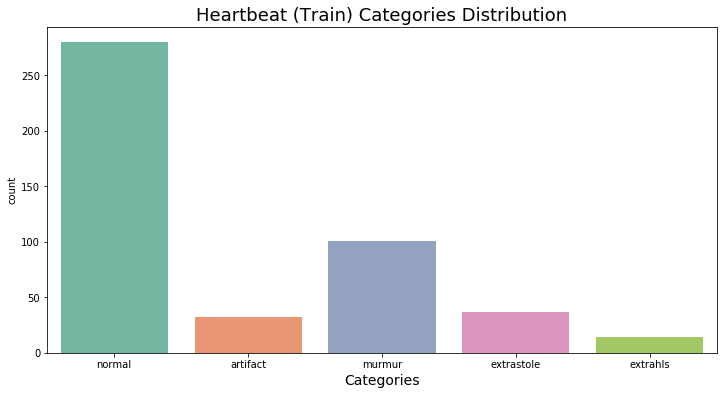

In [133]:
### Plot of categories distribution (original train dataset)
plt.figure(figsize = (12,6));
ax = sns.countplot(x = 'label', data = train, palette = 'Set2');
ax.set_title("Heartbeat (Train) Categories Distribution", fontsize=18);
ax.set_xlabel('Categories', fontsize=14);

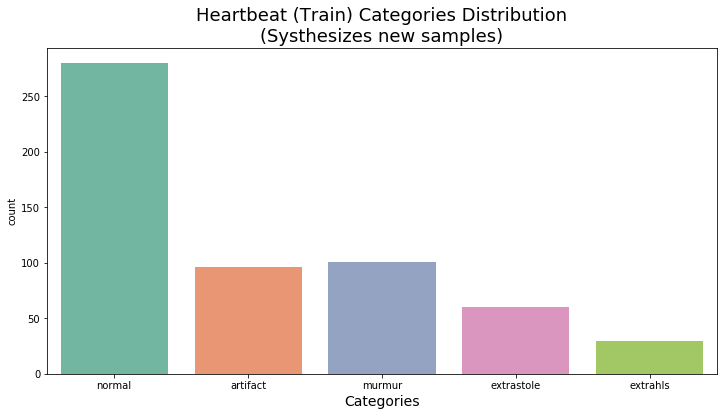

In [80]:
### Plot of categories distribution
#sns.set(style="darkgrid");
plt.figure(figsize = (12,6));
ax = sns.countplot(x = 'label', data = train_plus, palette = 'Set2');
ax.set_title(r"Heartbeat (Train) Categories Distribution"+"\n"+"(Systhesizes new samples)", fontsize=18);
ax.set_xlabel('Categories', fontsize=14);

### 4.3.2 Over-sampling minority categories
- The majority class, `normal` heartbeat sound is now reduce to **49.6%**. It is still highly imbalanced.
- This steip is to **oversample** the remaining categories to **twice their original sample size**, by random sampling with replacement.

In [81]:
### on original train data set only
### Split dataframe by category
majority_cat = train_plus[train_plus['label'] == 'normal']
min_cat_1 = train_plus[train_plus['label'] == 'artifact']
min_cat_2 = train_plus[train_plus['label'] == 'extrahls']
min_cat_3 = train_plus[train_plus['label'] == 'extrastole']
min_cat_4 = train_plus[train_plus['label'] == 'murmur']

### function for resample with replacement
def min_cat_upsampled(min_cat, sample_size):
    min_cat_upsampling = resample(min_cat,
                                  replace = True,
                                  n_samples = sample_size,
                                  random_state = 42)
    return min_cat_upsampling

### upsample the minority category
min_cat_1 = min_cat_upsampled(min_cat_1, min_cat_1.shape[0]*2)
min_cat_2 = min_cat_upsampled(min_cat_2, min_cat_2.shape[0]*2)
min_cat_3 = min_cat_upsampled(min_cat_3, min_cat_3.shape[0]*2)
min_cat_4 = min_cat_upsampled(min_cat_4, min_cat_4.shape[0]*2)

### combine all 5 category into 1 dataframe (this is synthesize = oversampling df)
train_plus_os = pd.concat([majority_cat, min_cat_1, min_cat_2, min_cat_4, min_cat_3 ])


In [85]:
from sklearn.utils import shuffle

# Shuffles dataset to inject randomness
train_plus = shuffle(train_plus)
train_plus_os = shuffle(train_plus_os)
train_plus.reset_index(drop = True, inplace = True)
train_plus_os.reset_index(drop = True, inplace = True)

# check the sample size per category after upsampling
train_plus_os.groupby('label')['filename'].count()

label
artifact      192
extrahls       60
extrastole    120
murmur        202
normal        280
Name: filename, dtype: int64

In [86]:
# check the sample size per category after upsampling by percentage
round(train_plus_os.groupby('label')['filename'].count()/train_plus_os.shape[0]*100,1)

label
artifact      22.5
extrahls       7.0
extrastole    14.1
murmur        23.7
normal        32.8
Name: filename, dtype: float64

In [87]:
### export df with imbalance class treatment to csv file
train_plus.to_csv('../outputs/train_plus.csv', index = False)
train_plus_os.to_csv('../outputs/train_plus_os.csv', index = False)

The `normal` category now further reduce to **32.8%**. The third step (impose class weights) will be done in later stage, after `train-test-split` the X-feature matrix.

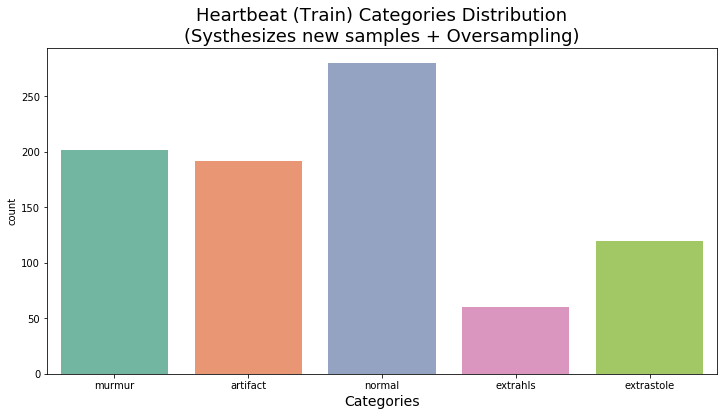

In [91]:
### Plot of categories distribution
#sns.set(style="darkgrid");
plt.figure(figsize = (12,6));
ax = sns.countplot(x = 'label', data = train_plus_os, palette = 'Set2');
ax.set_title(r"Heartbeat (Train) Categories Distribution"+"\n"+"(Systhesizes new samples + Oversampling)", fontsize=18);
ax.set_xlabel('Categories', fontsize=14);

## 4.4 Feature Extractions from audio wav 

I will have two sets of features to model separately. The first feature is **DWT + MFCC** and the second set of feature is **CWT**.

## 4.4.1 MFCC feature extraction
- Load and compile the audio with signal duration >1 sec.
- Standardize the length of audio to be 3 sec.
- zero padding on those < 3 sec audio wav.
- post trancate on those > 3 sec audio wav.

In [92]:
### Function for zero padding
def zero_pad(data, file_length, pad, truncate):
    data = pad_sequences(data, maxlen = file_length, dtype = 'float',
                       padding = pad, truncating= truncate, value = 0.)
    return data

In [94]:
%%time
### load labeled dataset (i.e.: both train & test), zero pad for audio wav < 3sec. Truncate for audio wav>4sec
### resuls of data_ab are compilation of data with the same length of samples (3*sfreq)
sfreq = 22050

data_train, data_test = [], []    # this is with synthesize audio + oversampling on train set

for file in train_plus_os.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_train.append(y)

for file in test.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_test.append(y)

### post zero pad on audio wav < 3sec, take the 1st 3 sec on audio and truncate the remaining
data_train = zero_pad(data_train, sfreq*3, 'post', 'post')
data_test = zero_pad(data_test, sfreq*3, 'post', 'post')


CPU times: user 34 s, sys: 1.21 s, total: 35.2 s
Wall time: 36.8 s


In [95]:
%%time
### repeat the same for unlabel dataset
### keep set a & set b seperated as the evaluation csv from kaggle remain separated
data_aunlabel, data_bunlabel = [], []
for file in df_aunlabel_sorted.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_aunlabel.append(y)

for file in df_bunlabel_sorted.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_bunlabel.append(y)

data_aunlabel = zero_pad(data_aunlabel, sfreq*3, 'post', 'post')
data_bunlabel = zero_pad(data_bunlabel, sfreq*3, 'post', 'post')


CPU times: user 9.96 s, sys: 402 ms, total: 10.4 s
Wall time: 11 s


## 4.4.1.1 Function to extract MFCC:

1. Denoise using DWT
2. MFCC feature extraction
3. Normalization of MFCC 

In [96]:
### Function to pre-process and then extract the MFCC feature
def extract_feature(data, sr):
    
    # denoise audio signal
    x_denoise = denoise_signal(data)
    
    # extract mfcc feature
    mfccs = lr.feature.mfcc(y = x_denoise, sr = sr, n_mfcc = 20)
    
    # mfccs normalization [0,1]
    mfccs_sc = feature_normalize(mfccs)
    
    return mfccs_sc

### Extract X-features

- These includes **train, test** datasets and also the unlabel dataset from set_a & set_b
- The data is with imbalance class treatment (synthesize new sample + oversampling)

In [97]:
%%time

X_train, X_test, X_aunlabel, X_bunlabel = [], [], [], []

for i in range(len(data_train)):
    X_train.append(extract_feature(data_train[i], sfreq))
    
for i in range(len(data_test)):
    X_test.append(extract_feature(data_test[i], sfreq))

for j in range(len(data_aunlabel)):
    X_aunlabel.append(extract_feature(data_aunlabel[j], sfreq))

for k in range(len(data_bunlabel)):
    X_bunlabel.append(extract_feature(data_bunlabel[k], sfreq))

CPU times: user 29.9 s, sys: 2.2 s, total: 32.1 s
Wall time: 21.4 s


In [98]:
### change X to array
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_aunlabel = np.asarray(X_aunlabel)
X_bunlabel = np.asarray(X_bunlabel)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_aunlabel: {X_aunlabel.shape}')
print(f'X_bunlabel: {X_bunlabel.shape}')

X_train: (854, 20, 130)
X_test: (117, 20, 130)
X_aunlabel: (52, 20, 130)
X_bunlabel: (195, 20, 130)


### get the target: y_train & y_test 

This can be share with 2nd set of feature (CWT)

In [134]:
### Extract label as y-target and one-hot encode to integer
y_train = train_plus_os.label
y_test = test.label

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# to get back the label, use le.inverse_transform(ys)
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y_train: (854,)
y_test: (117,)


## 4.4.1.2 Compute class weight

This is the 3rd step of treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only). This steps need to repeat for 2nd set of feature (CWT)

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [135]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
print(f"class weights: {class_weights}")
print(f"class        : {np.unique(le.inverse_transform(y_train))}")

class weights: [0.88958333 2.84666667 1.42333333 0.84554455 0.61      ]
class        : ['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']


## 4.4.1.3 Re-shape X and change y to dummies

In [136]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_aunlabel = X_aunlabel.reshape(X_aunlabel.shape[0], X_aunlabel.shape[1], X_aunlabel.shape[2], 1)
X_bunlabel = X_bunlabel.reshape(X_bunlabel.shape[0], X_bunlabel.shape[1], X_bunlabel.shape[2], 1)

### change int categorical to dummies
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'shape X_train : {X_train.shape}')
print(f'shape X_test : {X_test.shape}')
print(f'shape X_aunlabel : {X_aunlabel.shape}')
print(f'shape X_bunlabel : {X_bunlabel.shape}')
print(f'shape y_train : {y_train.shape}')
print(f'shape y_test : {y_test.shape}')

shape X_train : (854, 20, 130, 1)
shape X_test : (117, 20, 130, 1)
shape X_aunlabel : (52, 20, 130, 1)
shape X_bunlabel : (195, 20, 130, 1)
shape y_train : (854, 5)
shape y_test : (117, 5)


## 4.4.1.4 Store the pre-processed data for modelling in the next notebook

In [137]:
### store the preprocessed data for use in the next notebook

%store X_train 
%store X_test 
%store y_train 
%store y_test 
%store X_aunlabel
%store X_bunlabel
%store le
%store class_weights

Stored 'X_train' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'X_aunlabel' (ndarray)
Stored 'X_bunlabel' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights' (ndarray)


## 4.4.2 CWT feature extraction

- Load and compile the audio, **DOWNSampling to 2kHz** with signal duration >1 sec. This is due to it will reduces the CWT feature significantly (2kHz * 3sec long Vs 22050Hz * 3 sec long). It is still okay to down-sample as the heartbeat audio is at low frequency, i.e. much lower than 1kHz (Nyquist frequency of 2kHz sampling rate).
- Standardize the length of audio to be 3 sec. 
- zero padding on those < 3 sec audio wav.
- post trancate on those > 3 sec audio wav.

In [103]:
%%time
sfr = 2000

data_train_cwt, data_test_cwt = [], []  #Train set incl. imbalance class treatment

for file in train_plus_os.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_train_cwt.append(y)

for file in test.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_test_cwt.append(y)
    
### post zero pad on audio wav <3sec, take the 1st 3 sec on audio and truncate the remaining
data_train_cwt = zero_pad(data_train_cwt, sfr*3, 'post', 'post')
data_test_cwt = zero_pad(data_test_cwt, sfr*3, 'post', 'post')

CPU times: user 24.3 s, sys: 893 ms, total: 25.2 s
Wall time: 26.9 s


## Extract X-features (CWT ) 

- X_train_cwt: TRAIN set with imbalance class treatment(synthesize + oversampling)
- X_test_cwt: TEST set

In [104]:
%%time
### define the mother wavelet, and scales
waveletname = 'shan1.5-1.0'
period_length = 600 #up to 600Hz

# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   #len(scales) : 120

X_train_cwt = []
rescale_size = 120
from skimage.transform import resize

for i in range(len(data_train_cwt)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_train_cwt[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs 
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_train_cwt.append(rescale)

CPU times: user 19min 5s, sys: 21.5 s, total: 19min 27s
Wall time: 20min 35s


In [105]:
%%time
### define the mother wavelet, and scales
waveletname = 'shan1.5-1.0'
period_length = 600 #up to 600Hz

# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   #len(scales) : 120

X_test_cwt = []
rescale_size = 120
from skimage.transform import resize

for i in range(len(data_test_cwt)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_test_cwt[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_test_cwt.append(rescale)

CPU times: user 2min 37s, sys: 3.74 s, total: 2min 41s
Wall time: 2min 36s


In [106]:
### Change to array
X_train_cwt = np.asarray(X_train_cwt)
X_test_cwt = np.asarray(X_test_cwt)

print(f"X_train_cwt : {X_train_cwt.shape}")
print(f"X_test_cwt : {X_test_cwt.shape}")

X_train_cwt : (854, 120, 120)
X_test_cwt : (117, 120, 120)


### Extract CWT for unlabel dataset and save in X_aunlabel_cwt, X_bunlabel_cwt
This is unlabel dataset from kaggle

In [107]:
%%time

### load unlabel data and downsample to 2kHz, zero pad/post truncate to standardize audio length to 3sec.
sfr = 2000

data_aunlabel_cwt, data_bunlabel_cwt = [], []

### set a
for file in df_aunlabel_sorted.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_aunlabel_cwt.append(y)
### set b
for file in df_bunlabel_sorted.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_bunlabel_cwt.append(y)

### post zero pad on audio wav <3sec, take the 1st 3 sec on audio and truncate the remaining
data_aunlabel_cwt = zero_pad(data_aunlabel_cwt, sfr*3, 'post', 'post')
data_bunlabel_cwt = zero_pad(data_bunlabel_cwt, sfr*3, 'post', 'post')

CPU times: user 5.31 s, sys: 264 ms, total: 5.57 s
Wall time: 6.15 s


In [108]:
%%time

### Extract CWT for unlabel dataset and save in X_aunlabel_cwt, X_bunlabel_cwt
waveletname = 'shan1.5-1.0'
period_length = 600 #up to 600Hz

# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   #len(scales) : 120

X_aunlabel_cwt, X_bunlabel_cwt = [],[]
from skimage.transform import resize
rescale_size = 120

### set_a
for i in range(len(data_aunlabel_cwt)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_aunlabel_cwt[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs   
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_aunlabel_cwt.append(rescale)
    
### set_b
for i in range(len(data_bunlabel_cwt)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_bunlabel_cwt[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_bunlabel_cwt.append(rescale)

CPU times: user 6min 1s, sys: 8.21 s, total: 6min 10s
Wall time: 5min 51s


In [139]:
### Change X_cwt to array
X_aunlabel_cwt = np.asarray(X_aunlabel_cwt)
X_bunlabel_cwt = np.asarray(X_bunlabel_cwt)

### Reshape 
X_aunlabel_cwt = X_aunlabel_cwt.reshape(X_aunlabel_cwt.shape[0], X_aunlabel_cwt.shape[1], X_aunlabel_cwt.shape[2],1)
X_bunlabel_cwt = X_bunlabel_cwt.reshape(X_bunlabel_cwt.shape[0], X_bunlabel_cwt.shape[1], X_bunlabel_cwt.shape[2],1)

print(f"X_aunlabel_cwt : {X_aunlabel_cwt.shape}")
print(f"X_bunlabel_cwt : {X_bunlabel_cwt.shape}")

X_aunlabel_cwt : (52, 120, 120, 1)
X_bunlabel_cwt : (195, 120, 120, 1)


### 4.3.2.4 Re-shape X and change y to dummies

In [140]:
X_train_cwt = X_train_cwt.reshape(X_train_cwt.shape[0], X_train_cwt.shape[1], X_train_cwt.shape[2], 1)
X_test_cwt = X_test_cwt.reshape(X_test_cwt.shape[0], X_test_cwt.shape[1], X_test_cwt.shape[2], 1)

print(f'shape X_train_cwt : {X_train_cwt.shape}')
print(f'shape X_test_cwt : {X_test_cwt.shape}')
print(f'shape y_train : {y_train.shape}')
print(f'shape y_test : {y_test.shape}')

shape X_train_cwt : (854, 120, 120, 1)
shape X_test_cwt : (117, 120, 120, 1)
shape y_train : (854, 5)
shape y_test : (117, 5)


### 4.3.2.4 Store the pre-processed data for modelling in the next notebook

In [142]:
%store X_train_cwt
%store X_test_cwt
%store y_train
%store y_test
%store X_aunlabel_cwt
%store X_bunlabel_cwt

Stored 'X_train_cwt' (ndarray)
Stored 'X_test_cwt' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'X_aunlabel_cwt' (ndarray)
Stored 'X_bunlabel_cwt' (ndarray)


## 4.5 Feature Extraction withOUT Oversampling & Synthesize New Sample

- this is to evaluate the effectiveness of classifier model if the dataset is WITHOUT Imbalance class treatment

## 4.5.1 MFCC

In [112]:
%%time
### load labeled dataset (i.e.: both train & test), zero pad for audio wav < 3sec. Truncate for audio wav>3sec
### resuls of data_ab are compilation of data with the same length of samples (3*sfreq)
sfreq = 22050

data_train_0 = []

for file in train.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_train_0.append(y)

### post zero pad on audio wav < 4sec, take the 1st 4 sec on audio and truncate the remaining
data_train_0 = zero_pad(data_train_0, sfreq*3, 'post', 'post')

CPU times: user 18.2 s, sys: 748 ms, total: 18.9 s
Wall time: 20.2 s


In [113]:
%time
### Extract mfcc feature

X_train_0 = []

for i in range(len(data_train_0)):
    X_train_0.append(extract_feature(data_train_0[i], sfreq))
    
### change X to array
X_train_0 = np.asarray(X_train_0)

print(f'X_train_0: {X_train_0.shape}')
print(f'X_test: {X_test.shape}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
X_train_0: (464, 20, 130)
X_test: (117, 20, 130, 1)


In [144]:
### Extract label as y-target and one-hot encode to integer
y_train_0 = train.label

#le = LabelEncoder()
y_train_0 = le.transform(y_train_0)   #just transform, no need to re-fit


# to get back the label, use le.inverse_transform(y)
print(f"y_train_0: {y_train_0.shape}")
print(f"y_test: {y_test.shape}")

y_train_0: (464,)
y_test: (117, 5)


In [145]:
###Compute class weight (need new class weight for train set that is without imbalance class treatment)
class_weights_0 = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_0),
                                                 y_train_0)
print(f"class weights_0: {class_weights_0}")
print(f"class        : {np.unique(le.inverse_transform(y_train_0))}")

class weights_0: [2.9        6.62857143 2.50810811 0.91881188 0.33142857]
class        : ['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']


In [146]:
### Reshape X
X_train_0 = X_train_0.reshape(X_train_0.shape[0], X_train_0.shape[1], X_train_0.shape[2], 1)

### change int categorical to dummies
y_train_0 = to_categorical(y_train_0)

print(f'shape X_train_0 : {X_train_0.shape}')
print(f'shape X_test_0 : {X_test.shape}')           
print(f'shape y_train : {y_train_0.shape}')
print(f'shape y_test : {y_test.shape}')

### no change in test set and reuse the feature extraction & y-label for test set in section 4.4

shape X_train_0 : (464, 20, 130, 1)
shape X_test_0 : (117, 20, 130, 1)
shape y_train : (464, 5)
shape y_test : (117, 5)


In [147]:
### store the preprocessed data for use in the next notebook

%store X_train_0 
%store X_test 
%store y_train_0 
%store y_test 
%store le
%store class_weights_0

Stored 'X_train_0' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train_0' (ndarray)
Stored 'y_test' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights_0' (ndarray)


## 4.5.2 CWT
Without imbalance class treatment CWT feature extraction for X_train only

In [120]:
%%time
### Load the audio wav (no upsampling no systhesize new sample)
sfr = 2000

data_train_cwt_0 = []

for file in train.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_train_cwt_0.append(y)
    
### post zero pad on audio wav <3sec, take the 1st 3 sec on audio and truncate the remaining
data_train_cwt_0 = zero_pad(data_train_cwt_0, sfr*3, 'post', 'post')

CPU times: user 9.9 s, sys: 427 ms, total: 10.3 s
Wall time: 11.2 s


#### Extract CWT

In [121]:
%%time
### define wavelet
waveletname = 'shan1.5-1.0'
period_length = 600 #up to 600Hz

# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   #len(scales) : 120

X_train_cwt_0 = []
rescale_size = 120
from skimage.transform import resize

for i in range(len(data_train_cwt_0)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_train_cwt_0[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs 
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_train_cwt_0.append(rescale)

CPU times: user 10min 51s, sys: 13.1 s, total: 11min 4s
Wall time: 10min 8s


In [122]:
### Convert X to array
X_train_cwt_0 = np.asarray(X_train_cwt_0)

print(f"X_train_cwt_0: {X_train_cwt_0.shape}")

X_train_cwt_0: (464, 120, 120)


In [123]:
### Reshape X
X_train_cwt_0 = X_train_cwt_0.reshape(X_train_cwt_0.shape[0], X_train_cwt_0.shape[1], X_train_cwt_0.shape[2],1)

print(f"X_train_cwt_0: {X_train_cwt_0.shape}")
print(f"X_test_cwt: {X_test_cwt.shape}")

X_train_cwt_0: (464, 120, 120, 1)
X_test_cwt: (117, 120, 120, 1)


In [148]:
### Store the data for modelling in the next notebook

%store X_train_cwt_0
%store X_test_cwt 
%store y_train_0 
%store y_test 
%store le
%store class_weights_0

Stored 'X_train_cwt_0' (ndarray)
Stored 'X_test_cwt' (ndarray)
Stored 'y_train_0' (ndarray)
Stored 'y_test' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights_0' (ndarray)


## 4.5 Feature Extraction with Synthesize New Sample ONLY

- this is to evaluate the effectiveness of classifier model if imbalance class treatment with Synthesize new sample only

In [152]:
### DataFrame that gather train + synthesize audio oNLY
print(f"train_plus: {train_plus.shape}")

train_plus: (567, 5)


### 4.5.1 MFCC 
train + synthesize new sample only

In [153]:
%%time
### load labeled dataset (i.e.: both train & test), zero pad for audio wav < 3sec. Truncate for audio wav>4sec
### resuls of data_ab are compilation of data with the same length of samples (3*sfreq)
sfreq = 22050

data_train_1 = []

for file in train_plus.file_path:
    y, sr = lr.load(file, sr = sfreq, res_type = 'kaiser_fast')
    data_train_1.append(y)

### post zero pad on audio wav < 4sec, take the 1st 4 sec on audio and truncate the remaining
data_train_1 = zero_pad(data_train_1, sfreq*3, 'post', 'post')

CPU times: user 21.7 s, sys: 1.13 s, total: 22.9 s
Wall time: 24.5 s


In [156]:
%%time

X_train_1 = []

for i in range(len(data_train_1)):
    X_train_1.append(extract_feature(data_train_1[i], sfreq))


### change X to array
X_train_1 = np.asarray(X_train_1)

print(f'X_train_1: {X_train_1.shape}')
print(f'X_test: {X_test.shape}')

X_train_1: (567, 20, 130)
X_test: (117, 20, 130, 1)
CPU times: user 12.9 s, sys: 839 ms, total: 13.7 s
Wall time: 7.11 s


In [157]:
### Extract label as y-target and one-hot encode to integer
y_train_1 = train_plus.label

#le_1 = LabelEncoder()
y_train_1 = le.transform(y_train_1)

# to get back the label, use le.inverse_transform(ys)
print(f"y_train_1: {y_train_1.shape}")
print(f"y_test: {y_test.shape}")

y_train_1: (567,)
y_test: (117, 5)


In [159]:
###Compute class weight
class_weights_1 = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_1),
                                                 y_train_1)
print(f"class weights_1: {class_weights_1}")
print(f"class        : {np.unique(le.inverse_transform(y_train_1))}")

class weights_1: [1.18125    3.78       1.89       1.12277228 0.405     ]
class        : ['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']


In [161]:
### Reshape X
X_train_1 = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], X_train_1.shape[2], 1)

### change int categorical to dummies
y_train_1 = to_categorical(y_train_1)


print(f'shape X_train_1 : {X_train_1.shape}')
print(f'shape X_test : {X_test.shape}')
print(f'shape y_train_1 : {y_train_1.shape}')
print(f'shape y_test : {y_test.shape}')

shape X_train_1 : (567, 20, 130, 1)
shape X_test : (117, 20, 130, 1)
shape y_train_1 : (567, 5)
shape y_test : (117, 5)


In [162]:
### store the preprocessed data for use in the next notebook

%store X_train_1 
%store X_test 
%store y_train_1 
%store y_test 
%store le
%store class_weights_1

Stored 'X_train_1' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train_1' (ndarray)
Stored 'y_test' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights_1' (ndarray)


### 4.5.2 CWT
train + synthesize new sample only

In [165]:
%%time
### Load the audio wav (no upsampling no systhesize new sample)
sfr = 2000

data_train_cwt_1 = []

for file in train_plus.file_path:
    y, sfr = lr.load(file, sr = sfr, res_type = 'kaiser_fast')
    data_train_cwt_1.append(y)


### post zero pad on audio wav <3sec, take the 1st 3 sec on audio and truncate the remaining
data_train_cwt_1 = zero_pad(data_train_cwt_1, sfr*3, 'post', 'post')

CPU times: user 12.9 s, sys: 498 ms, total: 13.4 s
Wall time: 14.3 s


In [166]:
%%time
### define wavelet
waveletname = 'shan1.5-1.0'
period_length = 600 #up to 600Hz

# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, period_length+1, 5))   #len(scales) : 120

X_train_cwt_1 = []
rescale_size = 120
from skimage.transform import resize

for i in range(len(data_train_cwt_1)):
    # continuous wavelet transform 
    coefs, freq = pywt.cwt(data_train_cwt_1[i], scales, waveletname, 1)
    # resize the 2D cwt coeffs 
    rescale = resize(abs(coefs), (len(scales), rescale_size), mode = 'constant')
    X_train_cwt_1.append(rescale)

CPU times: user 13min 35s, sys: 19.4 s, total: 13min 54s
Wall time: 13min 8s


In [167]:
### Convert X to array
X_train_cwt_1 = np.asarray(X_train_cwt_1)

print(f"X_train_cwt_1: {X_train_cwt_1.shape}")

### Reshape X
X_train_cwt_1 = X_train_cwt_1.reshape(X_train_cwt_1.shape[0], X_train_cwt_1.shape[1], X_train_cwt_1.shape[2],1)

print(f"after reshape:")
print(f"X_train_cwt_1: {X_train_cwt_1.shape}")
print(f"X_test_cwt: {X_test_cwt.shape}")

X_train_cwt_1: (567, 120, 120)
after reshape
X_train_cwt_1: (567, 120, 120, 1)
X_test_cwt: (117, 120, 120, 1)


In [168]:
### Store the data for modelling in the next notebook

%store X_train_cwt_1
%store X_test_cwt
%store y_train_1 
%store y_test 
%store le
%store class_weights_1

Stored 'X_train_cwt_1' (ndarray)
Stored 'X_test_cwt' (ndarray)
Stored 'y_train_1' (ndarray)
Stored 'y_test' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights_1' (ndarray)


#### Proceed to notebook 3 for modelling and they are splits into notebook 3a, 3b, & 3c for different type of modelling